In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import cv2
import uuid
import datetime
import numpy as np
import compress_pickle as cpkl

from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class
from ss_baselines.common.utils import plot_top_down_map

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_DIR_PATH = f"AvNav_Oracle_Dataset_v0_2.5K"
# DATASET_DIR_PATH = f"SAVI_Oracle_Dataset_v0_10K" # Smaller scale dataset for tests

# Read the dataset statistics file.
dataset_stats_filepath = f"{DATASET_DIR_PATH}/dataset_statistics.bz2"
with open(dataset_stats_filepath, "rb") as f:
    r__dataset_stats = cpkl.load(f)

from pprint import pprint
pprint(r__dataset_stats)

{'action_cel_coefs': {0: 5.63063063063063,
                      1: 0.351123595505618,
                      2: 2.314814814814815,
                      3: 1.8436578171091447},
 'action_counts': {0: 111, 1: 1780, 2: 270, 3: 339},
 'action_probs': {0: 0.0444, 1: 0.712, 2: 0.108, 3: 0.1356},
 'scene_counts': {'E9uDoFAP3SH': 24,
                  'SN83YJsR3w2': 29,
                  'Vvot9Ly1tCj': 24,
                  'r47D5H71a5s': 34},
 'total_episodes': 111,
 'total_steps': 2500}


### Plotting some stats about the dataset

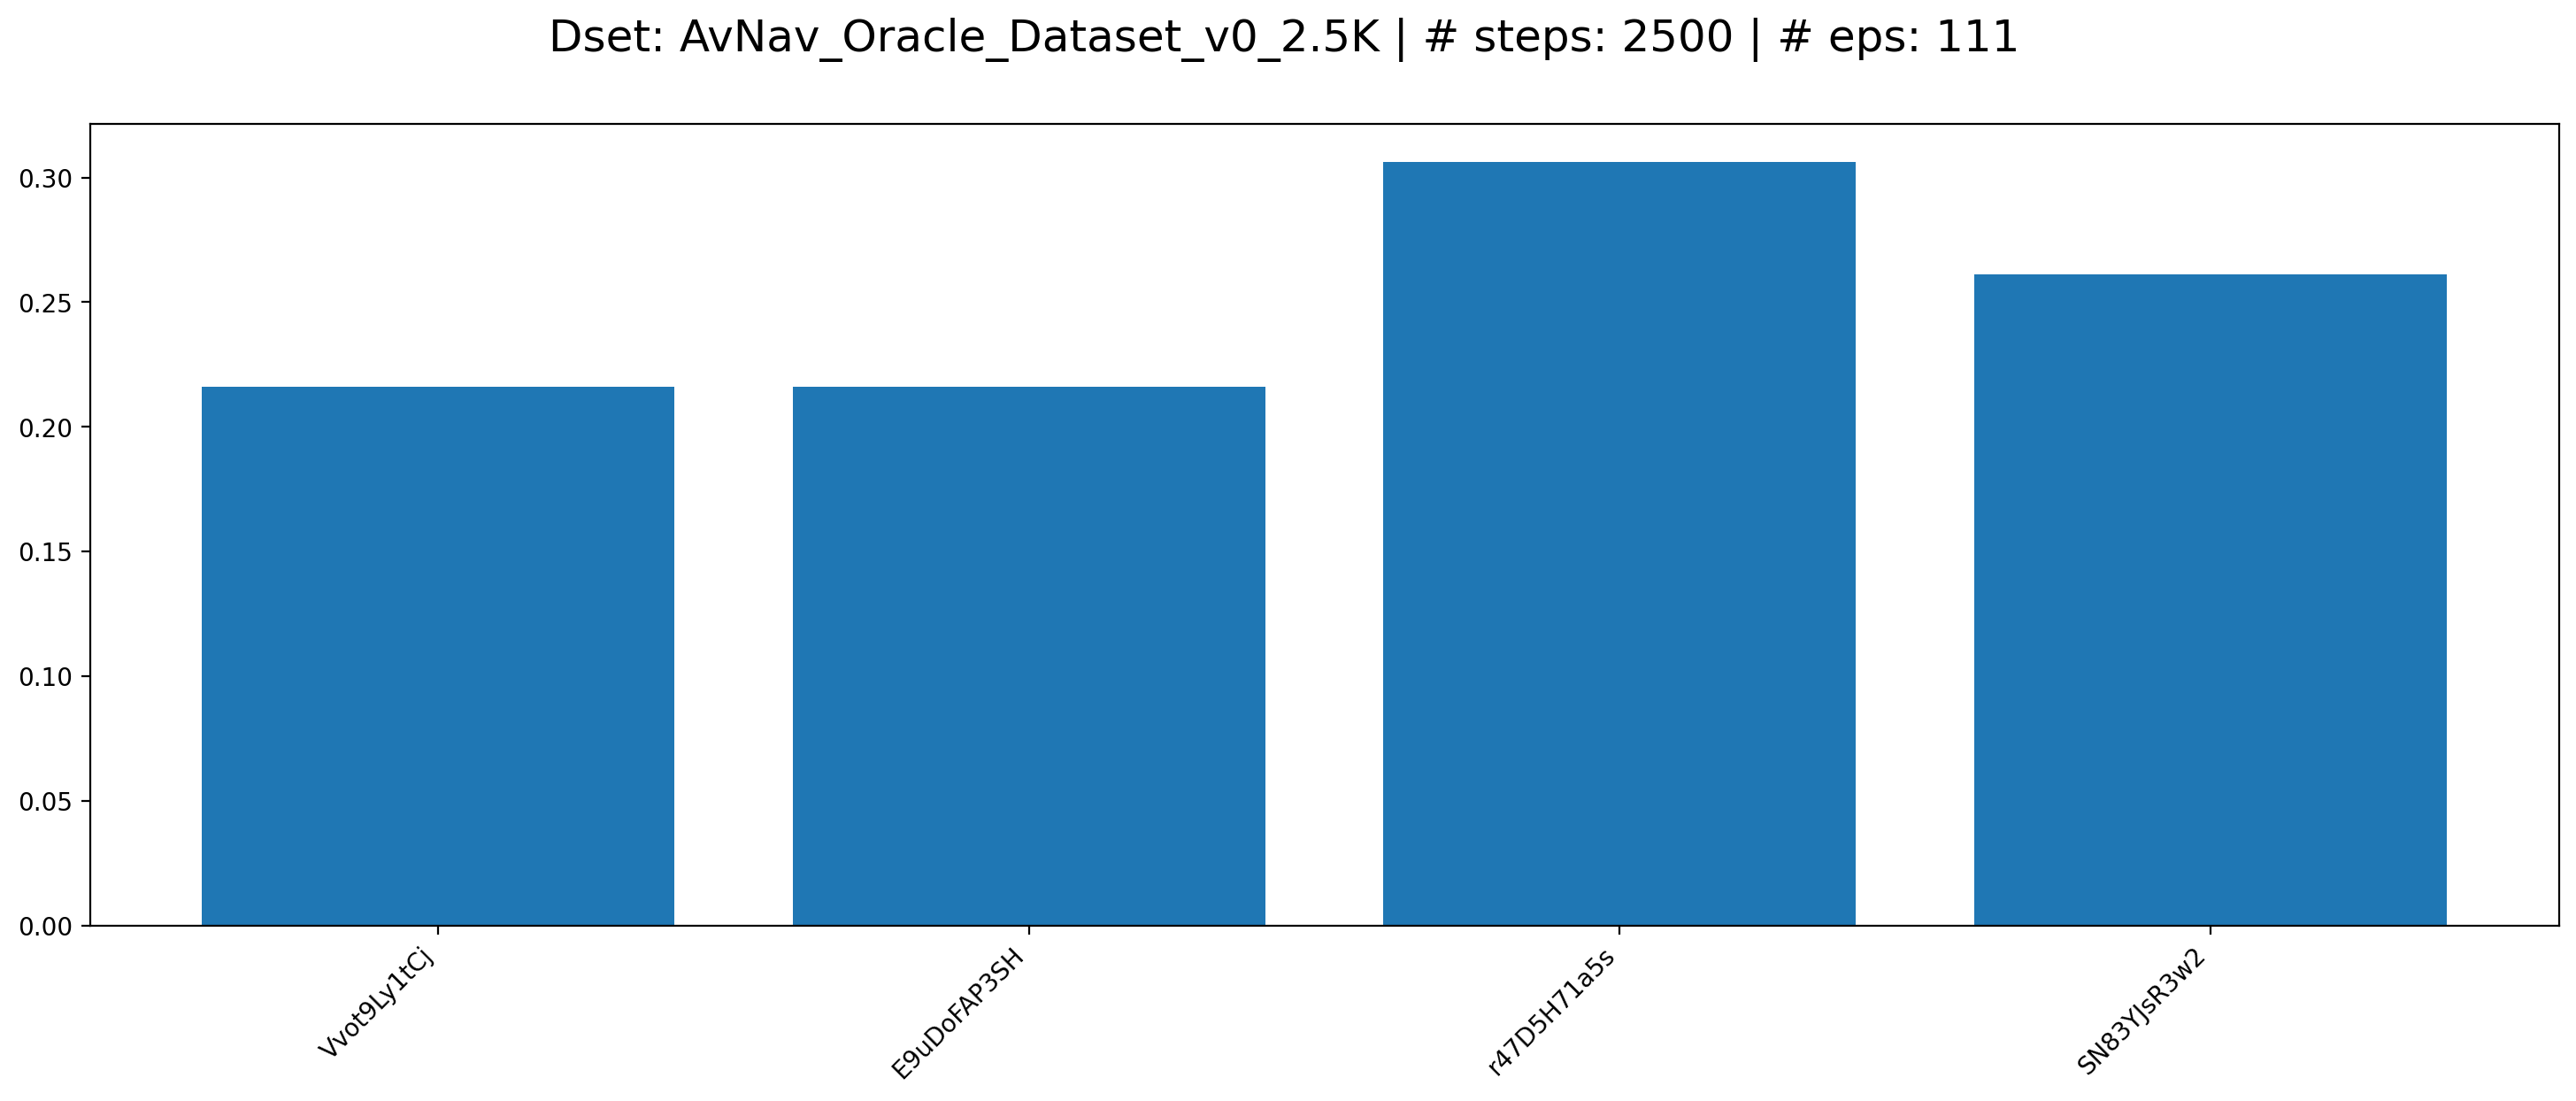

In [3]:
# Frequency of scenes in the dataset
total_episodes = np.sum([v for k, v in r__dataset_stats["scene_counts"].items()])
assert total_episodes == r__dataset_stats["total_episodes"], \
    "Scene counts not matching episode counts."
scene_probs = {k: v / total_episodes for k, v in r__dataset_stats["scene_counts"].items()}

fig, ax = plt.subplots(1,1, figsize=(6 * 3, 6), dpi=200)
x_labels, x_heights = [], []
for k, v in scene_probs.items():
    x_labels.append(k)
    x_heights.append(v)
n_scenes = len(x_labels)
x = [i for i in range(n_scenes)]

ax.bar(x=x, height=x_heights, tick_label=x_labels)
ax.set_xticklabels(x_labels, rotation=45, ha="right")
fig.suptitle(f"Dset: {DATASET_DIR_PATH} | # steps: {r__dataset_stats['total_steps']} | # eps: {r__dataset_stats['total_episodes']}", fontsize=18)
fig.show()

In [4]:
# # Frequency of the episode lengths
# all_ep_lengths = []
# ep_lengths_dict = {}
# for ep_filename in os.listdir(DATASET_DIR_PATH):
#     if ep_filename == "dataset_statistics.bz2":
#         continue
#     ep_filepath = f"{DATASET_DIR_PATH}/{ep_filename}"
#     with open(ep_filepath, "rb") as f:
#         edd = cpkl.load(f)
    
#     ep_length = edd["ep_length"]
#     if ep_length not in list(ep_lengths_dict.keys()):
#         ep_lengths_dict[ep_length] = 1
#     else:
#         ep_lengths_dict[ep_length] += 1
#     all_ep_lengths.append(ep_length)

# # Histogram of the episodes lengths, note that it is very time costly, since this was not logged during data collection.
# fig, ax = plt.subplots(1,1, figsize=(6 * 3, 6), dpi=200)
# ax.hist(all_ep_lengths, bins=60)

# Manual traj. checking

In [5]:
# Read filename list, remove the metatdata file
ep_filenames = os.listdir(f"{DATASET_DIR_PATH}")
if "dataset_statistics.bz2" in ep_filenames:
    ep_filenames.remove("dataset_statistics.bz2")

with open(f"{DATASET_DIR_PATH}/{ep_filenames[0]}", "rb") as f:
    edd = cpkl.load(f)

edd.keys() # dict_keys(['obs_list', 'highres_obs_list', 'action_list', 'done_list', 'reward_list', 'info_list', 'ep_length', 'scene_id'])
edd["obs_list"].keys() # dict_keys(['depth', 'rgb', 'audiogoal', 'spectrogram'])
edd["ep_length"]

36

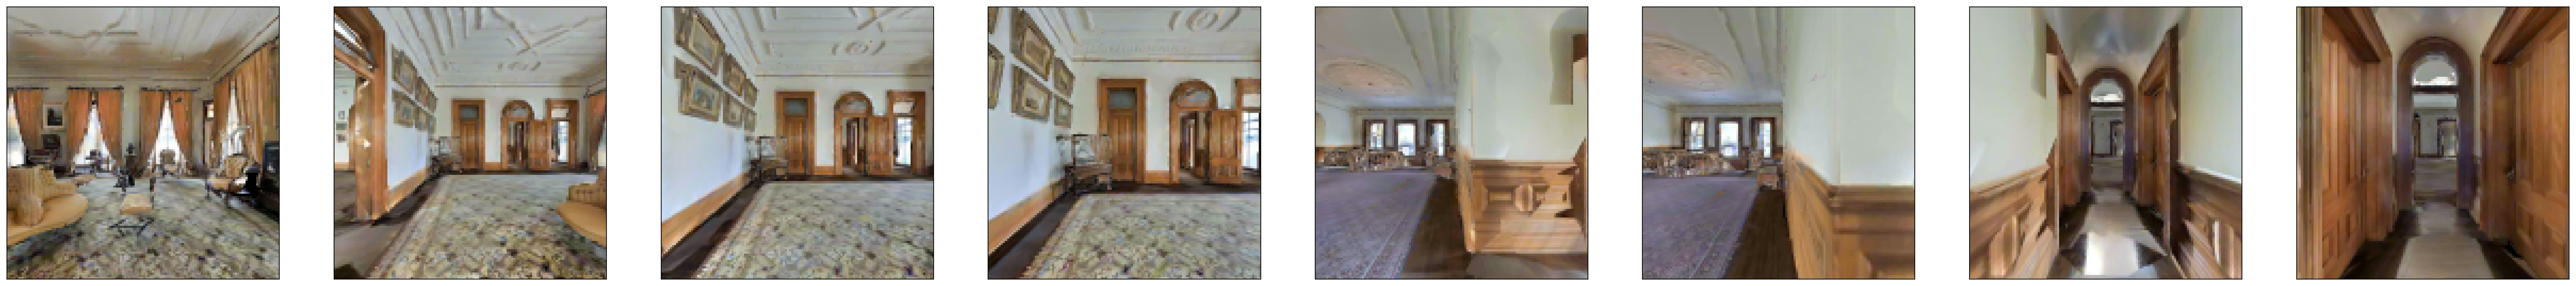

In [6]:
# Plot first and last N steps
N = 4
fig, axes = plt.subplots(1, N * 2, figsize=(6 * (N * 2), 6), dpi=200)
fig.set_facecolor("white")
truncated_obs_list = edd["obs_list"]["rgb"][:N] + edd["obs_list"]["rgb"][-N:]

for t, obs_dict in enumerate(truncated_obs_list):
    axes[t].imshow(obs_dict)
    axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
fig.show()

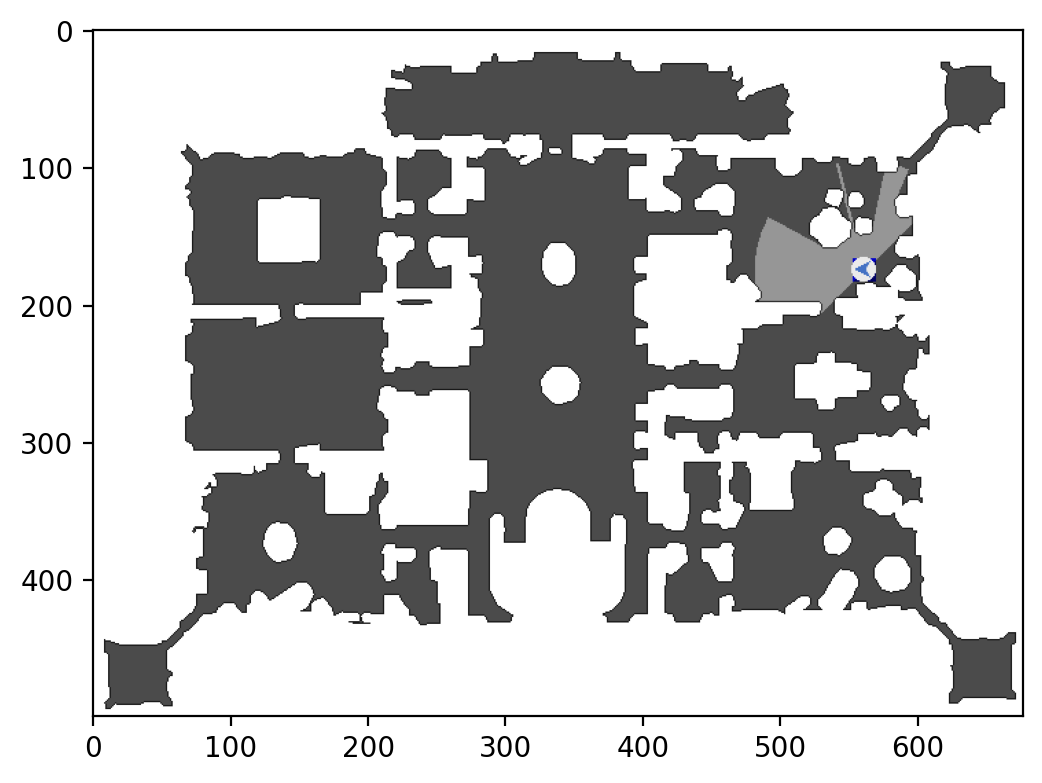

In [21]:
from ss_baselines.common.utils import plot_top_down_map

# Checking the info list, namely for top_down_map
edd["info_list"][0].keys() # dict_keys(['distance_to_goal', 'normalized_distance_to_goal', 'success', 'spl', 'softspl', 'na', 'sna', 'top_down_map'])
edd["info_list"][0]["top_down_map"].keys() # dict_keys(['map', 'fog_of_war_mask', 'agent_map_coord', 'agent_angle'])
# edd["info_list"][0]["top_down_map"]["map"].shape

top_down_map_img = plot_top_down_map(edd["info_list"][0], dataset="mp3d")
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=200)
# ax.imshow(edd["info_list"][0]["top_down_map"]["map"])
ax.imshow(top_down_map_img)
fig.show()

# Extracting trajectories for RSA